## 之前测试的过程  
（1）标签只能接受一维的模型，需要用OneVsRestClassifier进行转换  
比如LogisticRegression、SVC等  
（2）当存在属性decision_function时，用属性decision_function，无时，可用predict_proba进行替代  
https://stackoverflow.com/questions/36543137/whats-the-difference-between-predict-proba-and-decision-function-in-scikit-lear
（3）K近邻和Tree的predict_proba为三维，应用[:,:,1]（二维是应用[:,1]进行选择  
KNeighborsClassifier() #DecisionTreeClassifier,RandomForestClassifier  
https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier?rq=1   
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba  
（4）学会看官方文档  

# 图三：三分类的图-不同模型之间的比较

In [ ]:
（1）单因子效果，单个因子，不同监督学习上的表现
逐个遍历单因子，可以以RSI为例

In [1]:
import pandas as pd,numpy as np
df_returns=pd.read_pickle('returns')
df_RSI=pd.read_pickle('RSI')
df_MACD=pd.read_pickle('MACD')
df_CCI=pd.read_pickle('CCI')
df_CMO=pd.read_pickle('CMO')
df_ATR=pd.read_pickle('ATR')
df_BOP=pd.read_pickle('BOP')
df_MFI=pd.read_pickle('MFI')
df_ADOSC=pd.read_pickle('ADOSC')
df_BETA=pd.read_pickle('BETA')
# 去掉含na的股票
col_filter=df_returns.dropna(axis=1).columns
index_adj=df_returns.index[61:]
df_RSI_filter=df_RSI[col_filter].loc[index_adj]
df_MACD_filter=df_MACD[col_filter].loc[index_adj]
df_CCI_filter=df_CCI[col_filter].loc[index_adj]
df_CMO_filter=df_CMO[col_filter].loc[index_adj]
df_ATR_filter=df_ATR[col_filter].loc[index_adj]
df_BOP_filter=df_BOP[col_filter].loc[index_adj]
df_MFI_filter=df_MFI[col_filter].loc[index_adj]
df_ADOSC_filter=df_ADOSC[col_filter].loc[index_adj]
df_BETA_filter=df_BETA[col_filter].loc[index_adj]
df_returns_filter=df_returns[col_filter].loc[index_adj]

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifiers = [
    LogisticRegression(),
    MLPClassifier(),
    KNeighborsClassifier(),
    LinearSVC(multi_class='crammer_singer'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

## 单个图

In [4]:
num=10
df_returns_filter_mean=df_returns_filter.rolling(window=3).mean()
df_returns_rank=df_returns_filter_mean.rank(method='first',axis=1)
threshold_1=df_returns_rank.quantile(0.33,axis=1)
threshold_2=df_returns_rank.quantile(0.67,axis=1)
df_tmp=df_returns_rank.copy()
df_tmp=df_tmp.sub(threshold_1,axis=0)
df_tmp[df_tmp<0]=-1
df_tmp[df_tmp>0]=0
df_tmp2=df_returns_rank.copy()
df_tmp2=df_tmp2.sub(threshold_2,axis=0)
df_tmp2[df_tmp2>0]=1
df_tmp2[df_tmp2<0]=0
df_returns_adj=df_tmp+df_tmp2
index_tag=[i for i in range(len(df_returns_adj.index)) if i % num==0 and i != 0]
index_label=df_returns_adj.index[index_tag]
Y_init=df_returns_adj.loc[index_label].values
Y=Y_init.flatten()
df_list=[df_RSI_filter,df_MACD_filter,df_CCI_filter,df_CMO_filter,df_ATR_filter,df_BOP_filter,df_MFI_filter,df_ADOSC_filter,df_BETA_filter]
pred_temp2=[]
X_temp=df_list[0].values # 直接选用df_RSI_filter
X_temp=((X_temp.transpose()-np.mean(X_temp,axis=1))/np.std(X_temp,axis=1)).transpose() 
num_delete=len(X_temp) % num
width=X_temp.shape[1]
temp=np.reshape(X_temp[:-num_delete,:],(-1,num,width))
X_init=np.transpose(temp, [0, 2, 1])
X=np.reshape(X_init,(-1, X_init.shape[2]))
from sklearn.model_selection import train_test_split #random_state=1234
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25,random_state=None,stratify=Y)
clf=classifiers[0]  #cla_num
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(np.mean(prediction == y_test))  

0.5246353961371699


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)
classifier = OneVsRestClassifier(classifiers[0])
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

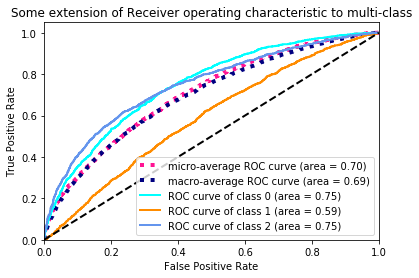

In [43]:
# Plot all ROC curves
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("examples.png")
plt.show()

# 多个图

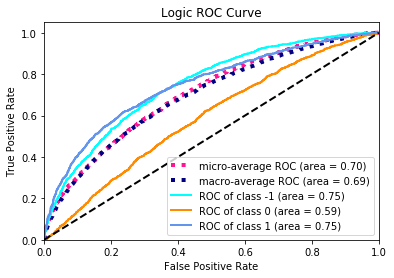

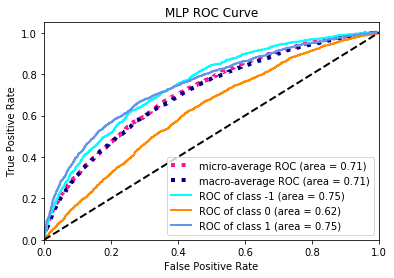

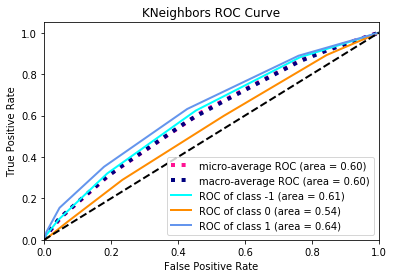

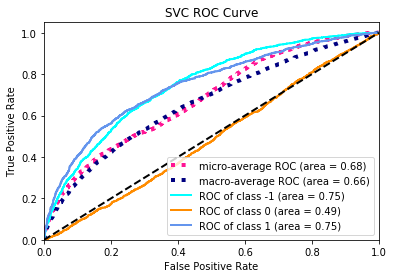

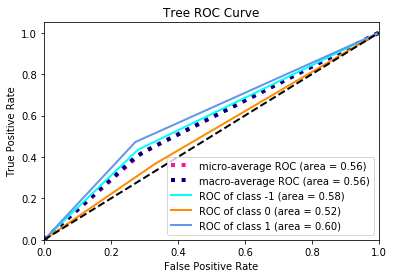

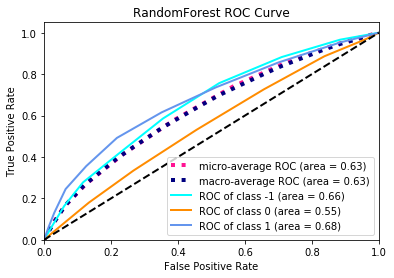

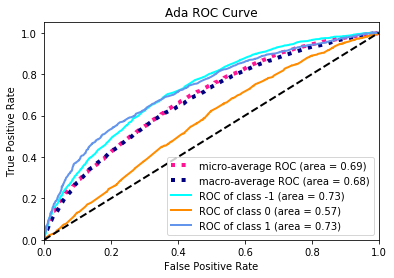

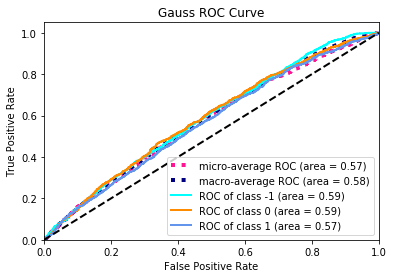

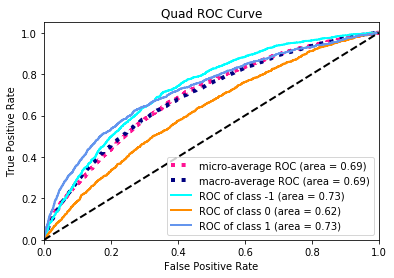

In [116]:
# classifiers = [
#     LogisticRegression(),
#     MLPClassifier(),
#     KNeighborsClassifier(),
#     LinearSVC(multi_class='crammer_singer'),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()]
lw = 2
ROC_name=['Logic ROC Curve','MLP ROC Curve','KNeighbors ROC Curve','SVC ROC Curve','Tree ROC Curve','RandomForest ROC Curve','Ada ROC Curve','Gauss ROC Curve','Quad ROC Curve']
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)
ROC_title=[]
for clf_num in range(len(classifiers)):
    classifier = OneVsRestClassifier(classifiers[clf_num])
    if hasattr(classifier, "decision_function"):
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    else:
        try:
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:,:,1].T
        except:
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Plot all ROC curves
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC of class {0} (area = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROC_name[clf_num])
    plt.legend(loc="lower right")
    plt.show()

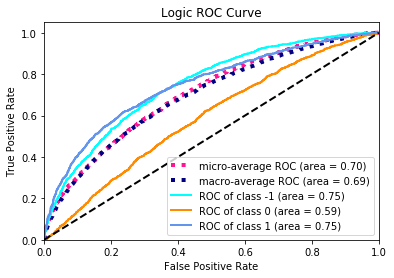

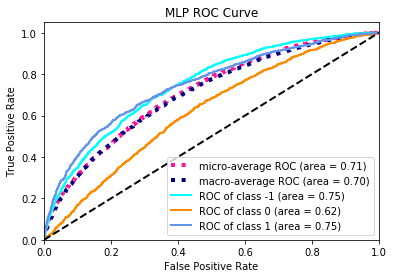

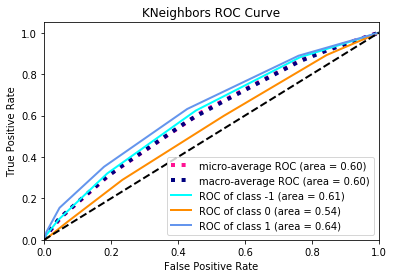

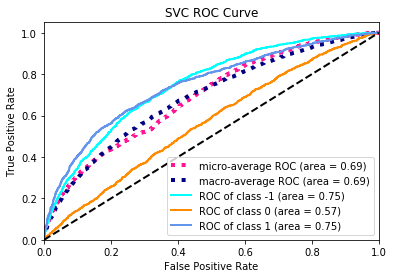

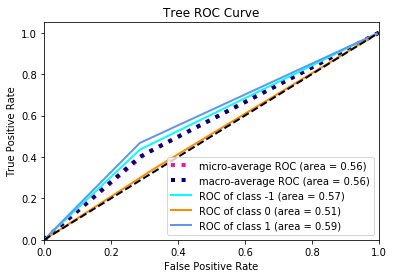

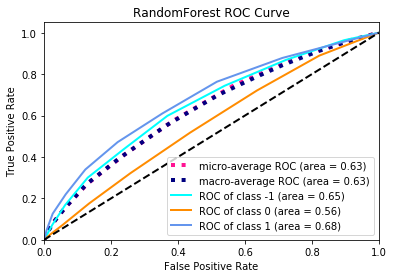

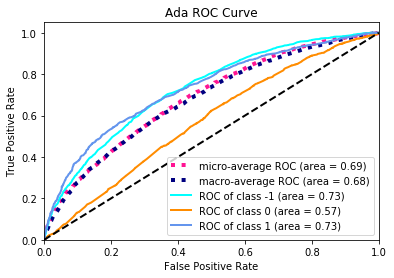

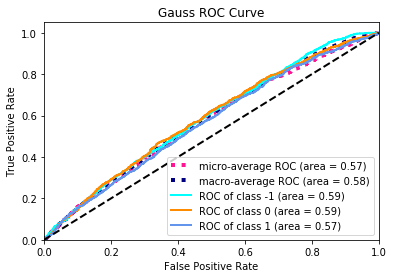

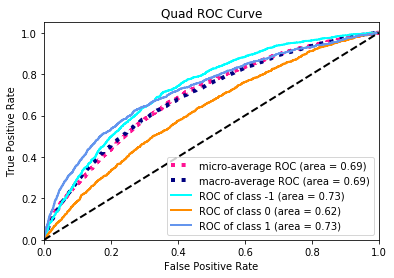

In [6]:
ROC_name=['Logic ROC Curve','MLP ROC Curve','KNeighbors ROC Curve','SVC ROC Curve','Tree ROC Curve','RandomForest ROC Curve','Ada ROC Curve','Gauss ROC Curve','Quad ROC Curve']
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)
ROC_title=[]
for clf_num in range(len(classifiers)):
    classifier = OneVsRestClassifier(classifiers[clf_num])
    if hasattr(classifier, "decision_function"):
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    else:
        try:
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:,:,0].T
        except:
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Plot all ROC curves
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC of class {0} (area = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROC_name[clf_num])
    plt.legend(loc="lower right")
    plt.show()

## 改标签，最终用于project中

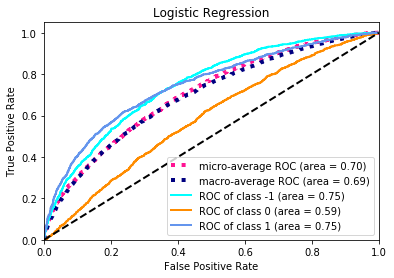

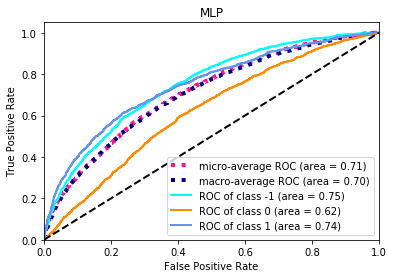

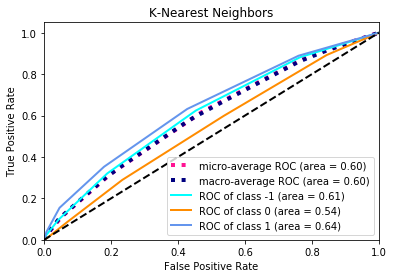

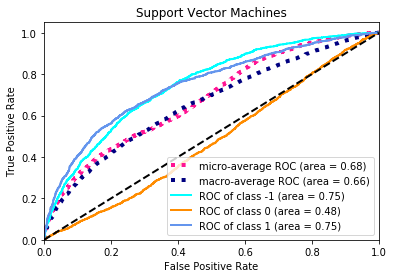

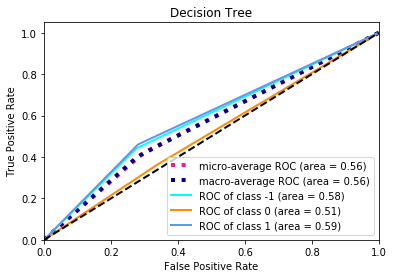

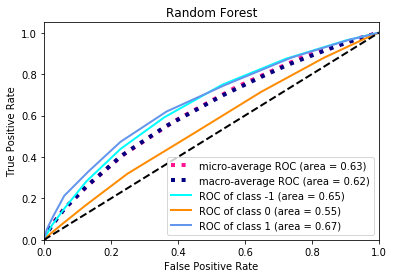

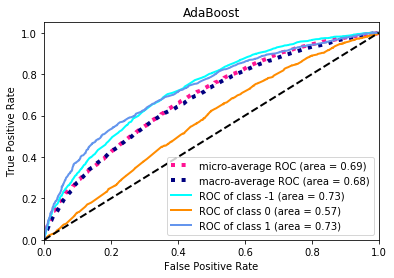

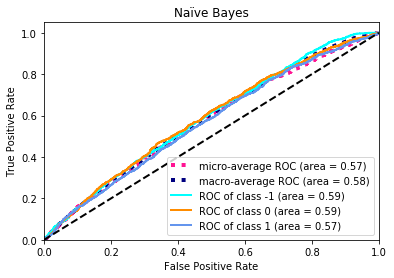

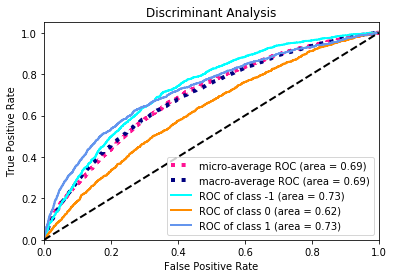

In [7]:
ROC_name=['Logistic Regression','MLP','K-Nearest Neighbors','Support Vector Machines','Decision Tree','Random Forest','AdaBoost','Naïve Bayes','Discriminant Analysis']
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)
ROC_title=[]
for clf_num in range(len(classifiers)):
    classifier = OneVsRestClassifier(classifiers[clf_num])
    if hasattr(classifier, "decision_function"):
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    else:
        try:
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:,:,0].T
        except:
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Plot all ROC curves
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC of class {0} (area = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROC_name[clf_num])
    plt.legend(loc="lower right")
    plt.show()

## 之前测试的过程  
（1）标签只能接受一维的模型，需要用OneVsRestClassifier进行转换  
比如LogisticRegression、SVC等  
（2）当存在属性decision_function时，用属性decision_function，无时，可用predict_proba进行替代  
https://stackoverflow.com/questions/36543137/whats-the-difference-between-predict-proba-and-decision-function-in-scikit-lear
（3）K近邻和Tree的predict_proba为三维，应用[:,:,1]（二维是应用[:,1]进行选择  
KNeighborsClassifier() #DecisionTreeClassifier,RandomForestClassifier  
https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier?rq=1   
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba  
（4）学会看官方文档

In [ ]:
MLPClassifier
KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
GaussianNB

In [101]:
classifier = OneVsRestClassifier(LogisticRegression())
y_score_intit = classifier.fit(X_train, y_train).decision_function(X_test)
y_score_intit

array([[-1.03872335, -0.54014704, -0.83580407],
       [-0.36198581, -0.42637976, -1.56601062],
       [-1.39008907, -0.91895126, -0.13989846],
       ...,
       [-0.29303617, -0.24182504, -1.78780734],
       [-1.38229164, -0.11429691, -0.90573249],
       [-1.11007608, -0.78125312, -0.53949806]])

In [103]:
classifier = MLPClassifier()
y_score= classifier.fit(X_train, y_train).predict_proba(X_test)
y_score

array([[0.25321227, 0.45095293, 0.2625382 ],
       [0.47759361, 0.41675994, 0.12617734],
       [0.1864633 , 0.31803494, 0.43193228],
       ...,
       [0.45517261, 0.45894764, 0.12248839],
       [0.19517485, 0.49690946, 0.26977278],
       [0.2287605 , 0.36239816, 0.36030995]])

In [114]:
classifier = OneVsRestClassifier(MLPClassifier())
y_score= classifier.fit(X_train, y_train).predict_proba(X_test)
y_score

array([[0.2357268 , 0.43158766, 0.26370699],
       [0.41071549, 0.44177027, 0.13713509],
       [0.17544725, 0.34572154, 0.46048406],
       ...,
       [0.38989509, 0.44872851, 0.14536128],
       [0.18063564, 0.44221508, 0.2843066 ],
       [0.26861996, 0.34685949, 0.33554117]])

In [112]:
classifier = KNeighborsClassifier() #DecisionTreeClassifier,RandomForestClassifier
y_score= np.array(classifier.fit(X_train, y_train).predict_proba(X_test))[:,:,1].T
y_score

array([[0. , 1. , 0. ],
       [0.2, 0.8, 0. ],
       [0.4, 0.2, 0.4],
       ...,
       [0. , 0.8, 0.2],
       [0.6, 0.4, 0. ],
       [0.4, 0.4, 0.2]])

In [100]:
classifier = OneVsRestClassifier(GaussianNB())
y_score_intit = classifier.fit(X_train, y_train).predict_proba(X_test)
y_score_intit

array([[0.24654549, 0.65763297, 0.17655656],
       [0.20472905, 0.84211347, 0.09195146],
       [0.23640873, 0.59352959, 0.21999704],
       ...,
       [0.21591783, 0.85411179, 0.06727419],
       [0.2097537 , 0.80064374, 0.09800208],
       [0.27155601, 0.47741332, 0.26216858]])

In [ ]:
classifiers = [
    LogisticRegression(),
    MLPClassifier(),
    KNeighborsClassifier(),
    LinearSVC(multi_class='crammer_singer'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]